In [63]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import scraper
import pickle
from pprint import pprint

In [4]:
def priceChanges(prices):
    absChange = [0]*(len(prices)-1)
    percChange = [0]*(len(prices)-1)
    for i in range(0,len(prices)-1):
        absChange[i] = prices[i+1]-prices[i]
        percChange[i] = absChange[i]/prices[i]
    return absChange,percChange

def marginChanges(prices,buylimit):
    absChange = [0]*(len(prices)-1)
    percChange = [0]*(len(prices)-1)
    for i in range(0,len(prices)-1):
        absChange[i] = prices[i+1]*buylimit-prices[i]*buylimit
        percChange[i] = absChange[i]/(prices[i]*buylimit)
    return absChange,percChange

In [5]:
itemInfo = scraper.loadItemInfo()

In [6]:
#col 13 = exchangePrice
natPrice = scraper.getExchangeInfo('Nature_rune')['price']
profits = []
for item in itemInfo:
    try:
        #print(int(item['exchangePrice'])+natPrice,int(item['highAlch']))
        exPrice = int(item['exchangePrice'])
        alchPrice = int(item['highAlch'])
        if exPrice!=-1 and exPrice+natPrice < alchPrice:
            #print(item)
            buyLimit = int(item['buyLimit'])
            profits.append((item,alchPrice/(exPrice+natPrice)))
    except ValueError:
        pass
def getKey(item):
    return item[1]
profits.sort(key=getKey,reverse=True)
#pprint(profits[:10])

In [50]:
itemPrices = scraper.loadItemPrices()


In [51]:
# remove items that were only added after the GE was added
minTime = itemPrices['Abyssal_whip'][0][0]
minItem = 'Abyssal_whip'
for item in itemPrices:
    if itemPrices[item][0][0]<minTime:
        minTime = itemPrices[item][0][0]
        minItem = item
print(minTime,minItem)

week = 604800

print(len(itemPrices))
for item in list(itemPrices.keys()):
    if itemPrices[item][0][0]>minTime+6*week:
        #print(item,itemPrices[item][0][0])
        del itemPrices[item]
print(len(itemPrices))
'''
for item in itemPrices:
    b = len(itemPrices[item])
    itemPrices[item] = [a for a in itemPrices[item] if a[0]>1470009000]
    a = len(itemPrices[item])
    if a<b:
        print(item,a-b)
'''

1424908800 Karambwan_vessel
3397
2031


'\nfor item in itemPrices:\n    b = len(itemPrices[item])\n    itemPrices[item] = [a for a in itemPrices[item] if a[0]>1470009000]\n    a = len(itemPrices[item])\n    if a<b:\n        print(item,a-b)\n'

In [100]:
def reject_outliers(data):
    top = np.quantile(data,.75)
    bottom = np.quantile(data,.25)
    IQR = top-bottom
    return [d for d in data if d>bottom-1.5*IQR and d<top+1.5*IQR]

def calculateCOV(arr):
    prices = [p[1] for p in arr[-100:]]
    #print(stats.variation(prices))
    prices = reject_outliers(prices)
    return stats.variation(prices)

In [53]:
print(calculateCOV(itemPrices['Blue_halloween_mask']))

KeyError: 'Blue_halloween_mask'

In [54]:
priceVariances = []
for item in itemPrices:
    priceVariances.append((calculateCOV(itemPrices[item]),item))

def getKey(item):
    return item[0]

priceVariances.sort(key=getKey,reverse=True)

In [55]:
pprint(priceVariances[:10])

[(0.6067477054221943, 'Nature_talisman'),
 (0.5648173402776151, 'Pie_dish'),
 (0.5285840784805326, 'Leaping_trout'),
 (0.5153881732163573, 'Leaping_salmon'),
 (0.4995856012228592, "Blue_d'hide_chaps_(g)"),
 (0.49762798388117563, 'Sickle_mould'),
 (0.4922483948230279, 'Adamant_platelegs_(g)'),
 (0.4865667921328762, 'Partyhat_set'),
 (0.4763484335904722, 'Purple_partyhat'),
 (0.473316212016648, 'Black_elegant_legs')]


In [91]:
def bollingerBands(data):
    means = []
    stds = []
    for i in range(20,len(data)):
        d = data[i-20:i]
        means.append(np.mean(d))
        stds.append(np.std(d))
    return np.array(means),np.array(stds)

def plotBollingerBands(data,means,stds):
    plt.figure(figsize=(20,10))
    plt.plot(means+2*stds,'r-')
    plt.plot(means+(-2*stds),'r-')
    plt.plot(means,'g--')
    plt.plot(data[20:],'b-')
    plt.show()
    

In [92]:
itemPrices = scraper.loadItemPrices()

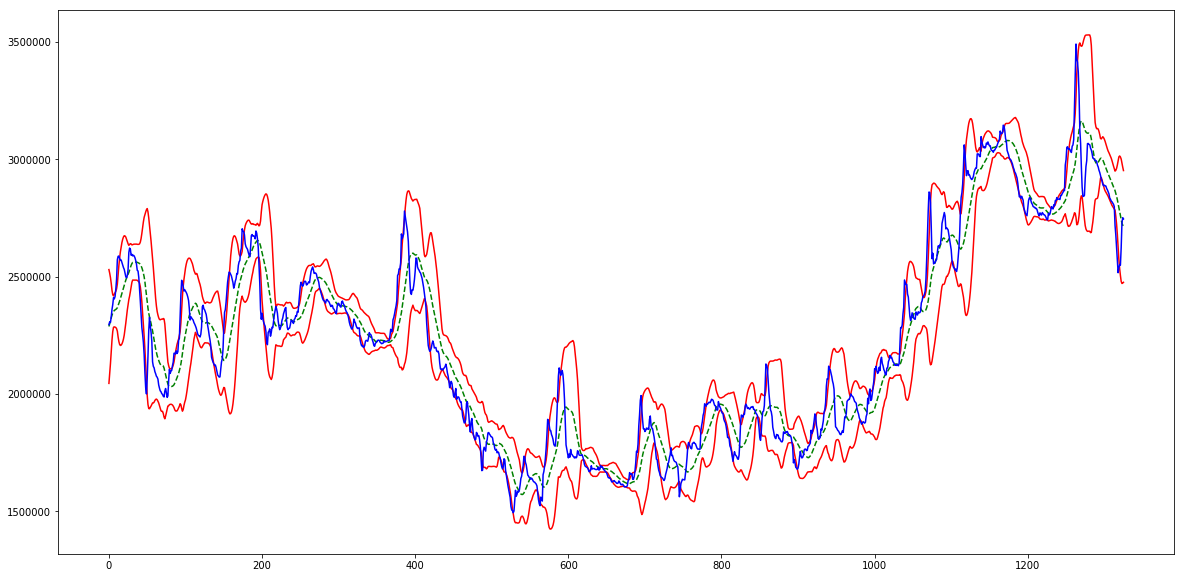

0.6491905224206455


In [98]:
prices = [a[1] for a in itemPrices['Abyssal_whip']]
means,stds = bollingerBands(prices)
plotBollingerBands(prices,means,stds)
print(np.std(stds)/np.mean(stds))

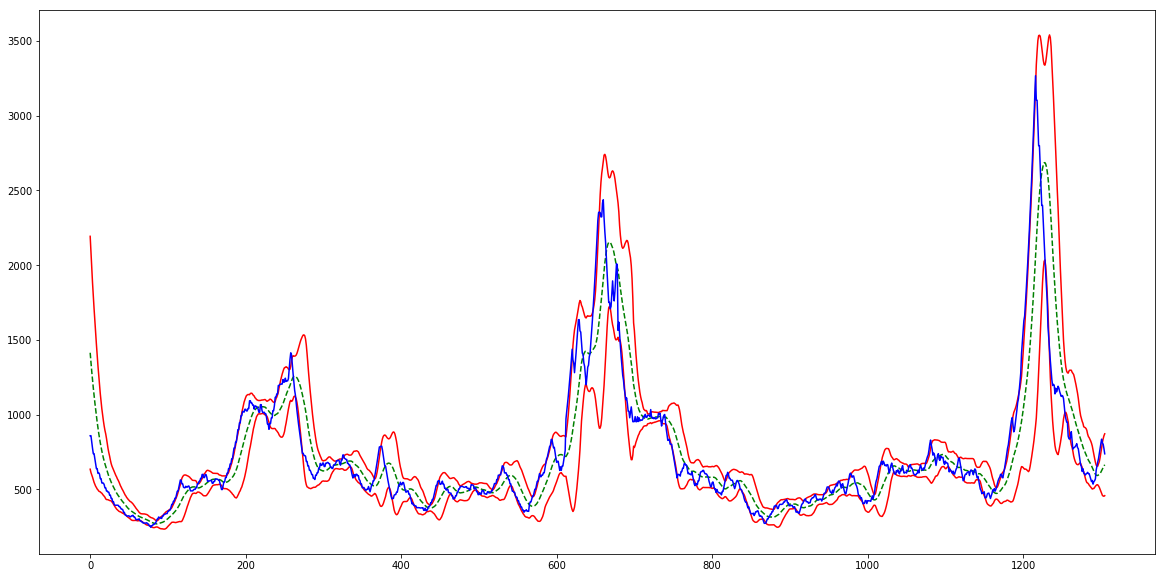

1.2370224893384907


In [101]:
prices = [a[1] for a in itemPrices['Nature_talisman']]
means,stds = bollingerBands(prices)
plotBollingerBands(prices,means,stds)
print(np.std(stds)/np.mean(stds))

In [ ]:
def getPerfectProfit(data):
    buyers = [10**5,10**6,10**7,10**8,10**9,10**10]
    profit = [0] * len(buyers)
    count = [0] * len(buyers)
    for i in range(1,len(data)):
        if data[i]>data[i-1]:
            for b in range(len(buyers)):
                amount = int(buyers[b]/data[i-1])
                profit[b] += (data[i]-data[i-1])*amount
                count[b] += amount
    for b in range(len(buyers)):
        if count[b] == 0:
            profit[b] == 0
        else:
            profit[b]/=count[b]
    return profit

In [ ]:
itemInfo = scraper.loadItemInfo()
itemPrices = scraper.loadItemPrices()

for item in itemPrices:
    prices = [a[1] for a in itemPrices[item]]
    mean = np.mean(prices)
    std = np.std(prices)
    itemPrices[item] = [itemPrices[item][i] for i in range(len(prices)) if prices[i]>mean+2*std]

In [ ]:
profits = []
for item in itemPrices:
    profits.append((getPerfectProfit([a[1] for a in itemPrices[item]]),item))

def getKey(item):
    return item[0][1]

profits.sort(key=getKey,reverse=True)